# Table of Contents
 <p>

In [41]:
# important stuff:
import os
import pandas as pd
import numpy as np
from IPython.core.display import HTML

# stats
import sklearn.decomposition
from scipy import stats as sts
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import statsmodels.api as stm

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

# bokeh
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html


# bayes and mcmc
import pymc3 as pm
import theano

# Display graphics in this notebook
bokeh.io.output_notebook()

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

from scipy.stats import gaussian_kde


ft = 35 #title fontsize

Loading BokehJS ...

In [2]:
import genpy
import gvars
import morgan

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [4]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [5]:
genvar = gvars.genvars()

In [6]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]

tidy_data = pd.concat(frames)

In [204]:
def label(code1, code2):
    """A function to make epistasis labels given two code-letters"""
    return '{0} $>$ {1}'.format(genvar.fancy_mapping[code1],
                                genvar.fancy_mapping[code2])


def find_overlap(genotypes, df, q=0.1):
    
    sig = df[(df.code.isin(genotypes)) & (df.qval < q)]
    grouped = sig.groupby('target_id')
    
    genes = []
    for target, group in grouped:
        if (group.qval < q).all() & (len(group.code.unique()) == len(genotypes)):
            genes += [target]
    
    return genes

genes = find_overlap(['b', 'd', 'a'], tidy_data)

def find_additive(single_muts, double_mut, df, q=0.1):
    if type(single_muts) is not list:
        raise ValueError('single_muts must be of type list')
    if type(double_mut) is not str:
        raise ValueError('double_mut must be of type str')
        
    genes = find_overlap(single_muts + [double_mut], df)
    x = tidy_data[(tidy_data.target_id.isin(genes)) & (tidy_data.code == single_muts[0])]
    y = tidy_data[(tidy_data.target_id.isin(genes)) & (tidy_data.code == single_muts[1])]
    xy = tidy_data[(tidy_data.target_id.isin(genes)) & (tidy_data.code == double_mut)]
    
    return x, y, xy


def weighted_regression_delta(singles, double, epistasis):
    """
    Given a prediction and a test,
    find the weighted least squares regression between them.
    """
    if len(singles) != 2:
        raise ValueError('`singles` must be a list with two dataframes!')
    
    X = singles[0].b + singles[1].b

    # fit a WLS
    # -1 is actual fit:
    if epistasis == -1:
        W = double.se_b**2
        for df in singles:
            W += df.se_b**2
        
        # WLS is dumb and takes Y, X IN THAT ORDER!
        wls = stm.WLS(double.b - X, X,
                      weights=1./W)

    if epistasis == 0:
        W = singles[1].se_b**2
        
        # if XY = X, then XY - X - Y = -Y
        wls = stm.WLS(-singles[1].b, X,
                     weights=1./W)
    
    if epistasis == 1:
        W = singles[0].se_b**2
        
        # if XY = Y, then XY - X - Y = -X
        wls = stm.WLS(-singles[0].b, X,
                     weights=1./W)

    res_wls = wls.fit()
    return res_wls


def print_WLS_summary(pair, slopes, res0, res1):
    """Print a string with the WLS results."""
    string = """mutant {0} slope: {1:.2g} +/- {2:.2g}, pvalue={3:.2g}"""
    print(string.format(pair[0], slopes[0],
                        res0.bse[0], res0.pvalues[0]))
    print(string.format(pair[1], slopes[1],
                        res1.bse[0], res1.pvalues[0]))
    
    
def plot_epistasis_regression(X, slope, **kwargs):
    """Plot the WLS line."""
    # find the xmin and xmax:
    xmin = X.min()
    xmax = X.max()
    
    # make a linear array for x
    x = np.linspace(xmin - 0.1, xmax + 0.1, 1000)
    
    # make the models
    y0 = x*slope
    
    # plot the models
    plt.plot(x, y0, **kwargs)

    
def epistasis_plot(singles, double, df, **kwargs):
    x, y, xy = find_additive(singles, double, df)
    actual = weighted_regression_delta([x,y], xy, -1)
    x_over_y = weighted_regression_delta([x,y], xy, 0)
    y_over_x = weighted_regression_delta([x,y], xy, 1)

    X = x.b + y.b
    Y = xy.b - X

    # Calculate the point density
    points = np.vstack([X,Y])
    z = gaussian_kde(points)(points)

    fig, ax = plt.subplots()
    if len(X) > 50:
        ax.scatter(X, Y, c=z, s=15/np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2),
                    edgecolor='', cmap='viridis', alpha=0.5)
    else:
        ax.scatter(X, Y, c=z, s=15/np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2),
                   edgecolor='', cmap='viridis', alpha=1)

#     plt.show()

#     plt.errorbar(X, Y, xerr=np.sqrt(x.se_b**2 + y.se_b**2),
#                  yerr=np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2),
#                  fmt='go', alpha=0.2, ms=4, label='data')
    

    plt.plot(X, -1/2*X, 'k-', lw=1.5, label='Unbranched Pathway')
    x_y_lab = label(singles[0], singles[1])
    y_x_lab = label(singles[1], singles[0])
    plot_epistasis_regression(X, actual.params[0], ls='-', lw=2, color='r', label='fit')
#     plot_epistasis_regression(X, x_over_y.params[0], ls='--', lw=3, color='b', label=x_y_lab)
#     plot_epistasis_regression(X, y_over_x.params[0], ls='--', lw=3, color='r', label=y_x_lab)
    
    plt.xlabel(r'Predicted Additive Effect, \beta_A + \beta_B')
    plt.ylabel(r'Deviation from Additive Effect, \beta_{AB} - \beta_A - \beta_B')
    
    plt.legend()
    
    return x, y, xy, x_over_y, y_over_x, actual


def curves(means, errors, labels, **kwargs):
    def normal(x, mu, sigma):
        return 1/(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))
    
    maxe = np.max(errors)
    maxm = np.max(means)
    minm = np.min(means)
    
    color = kwargs.pop('color', {})
    fill = kwargs.pop('fill', False)

    X = np.linspace(minm - 3*maxe, maxm+3*maxe, 1000)
    
    fig, ax = plt.subplots()
    for i, mean in enumerate(means):
        if labels[i] is 'fit':
            lw = 3
        else:
            lw = 2
        
        if len(color) > 0:
            plot = plt.plot(X, normal(X, mean, errors[i]),
                        label=labels[i], lw=lw, color=color[labels[i]])
        else:
            plot = plt.plot(X, normal(X, mean, errors[i]),
                        label=labels[i], lw=lw)
        if not fill:
            next

        if labels[i] is 'fit':
            ax.fill_between(X, 0, normal(X, mean, errors[i]), color='r', alpha=0.3)

    
    if minm - 3*maxe < -0.5 < maxm - 3*maxe:
        plt.gca().axvline(-0.5, color='k', ls='--', label='Unbranched Pathway')
    if minm - 3*maxe < 0 < maxm - 3*maxe:
        plt.gca().axvline(0, color='k', ls='-.', label='Additive Model')
    
    plt.legend(loc='upper right')
    plt.title('Epistasis Coefficient Predictions vs. Observed')
    plt.xlabel('Epistasis Coefficient')
    plt.ylabel('Density')

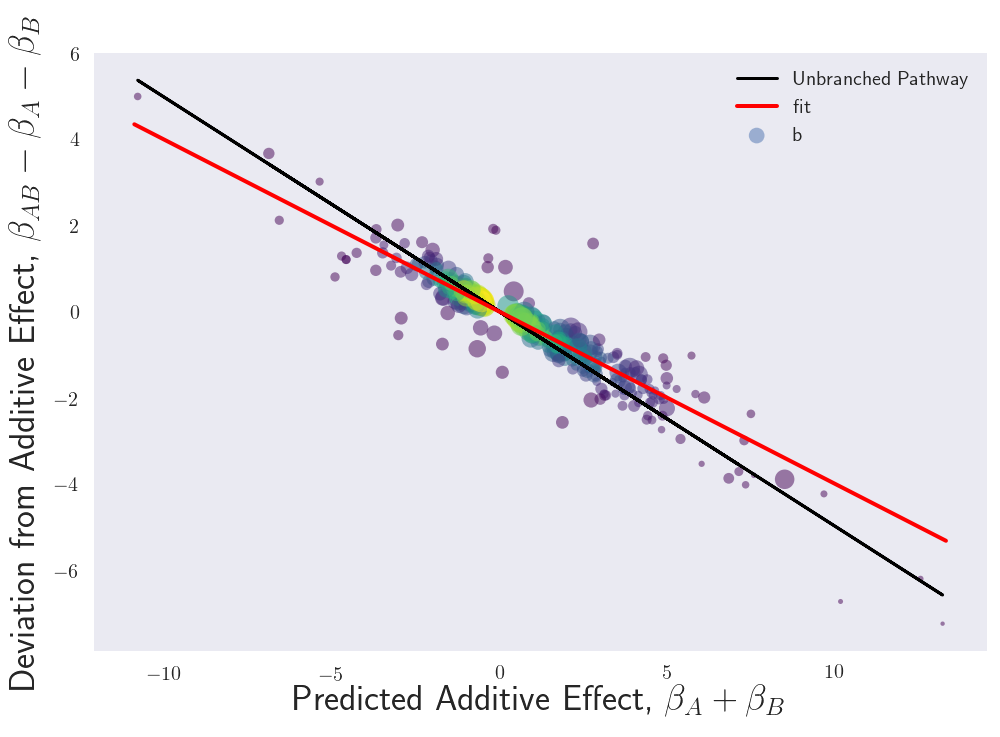

In [217]:
letter1 = 'b'
letter2 = 'd'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

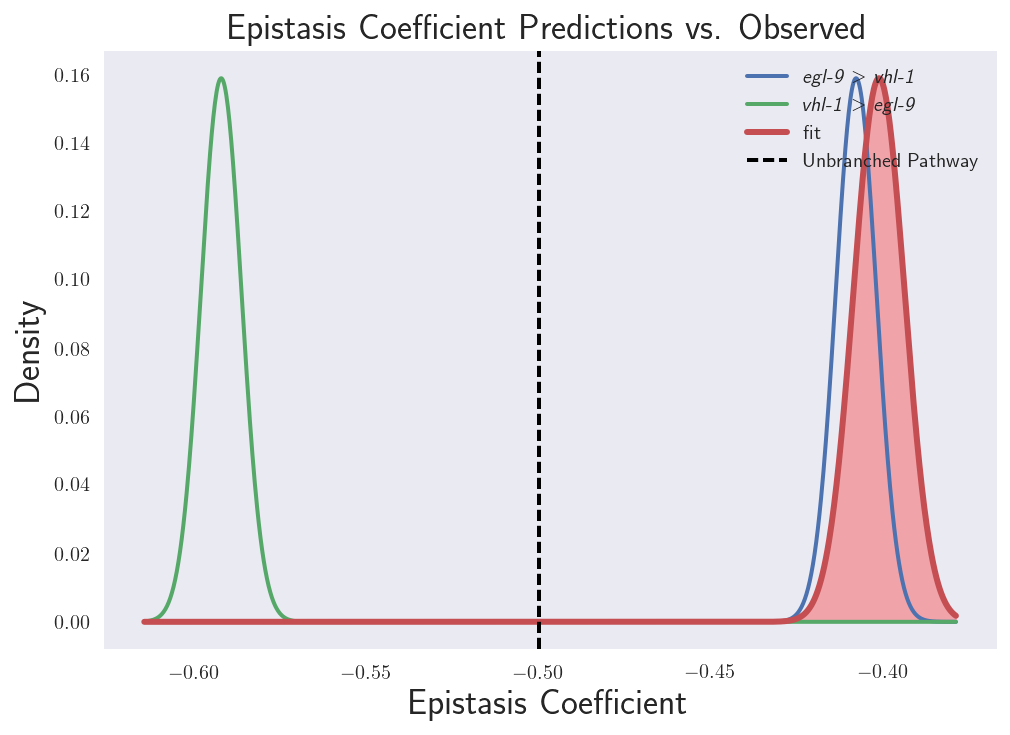

In [218]:
color = {label(letter1, letter2): 'b',
         label(letter2, letter1): 'g',
         'fit': 'r'
        }
curves([x_over_y.params[0], y_over_x.params[0], actual.params[0]],
       [x_over_y.bse[0], y_over_x.bse[0], actual.bse[0]],
       labels=[label(letter1, letter2), label(letter2, letter1), 'fit'])

plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

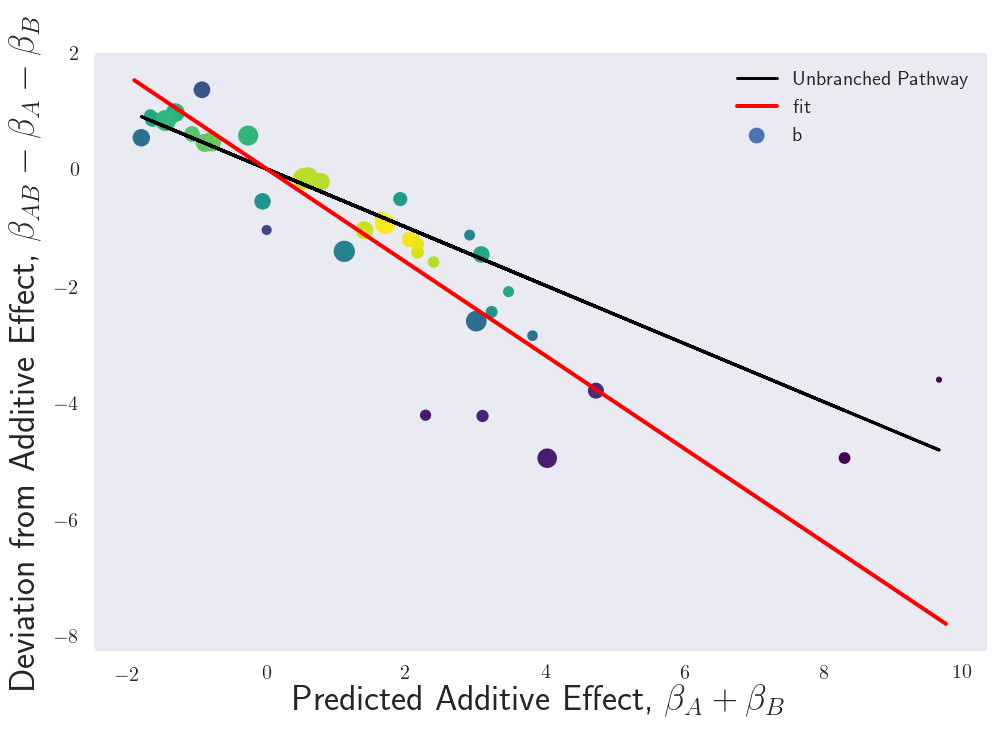

In [220]:
letter1 = 'b'
letter2 = 'c'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

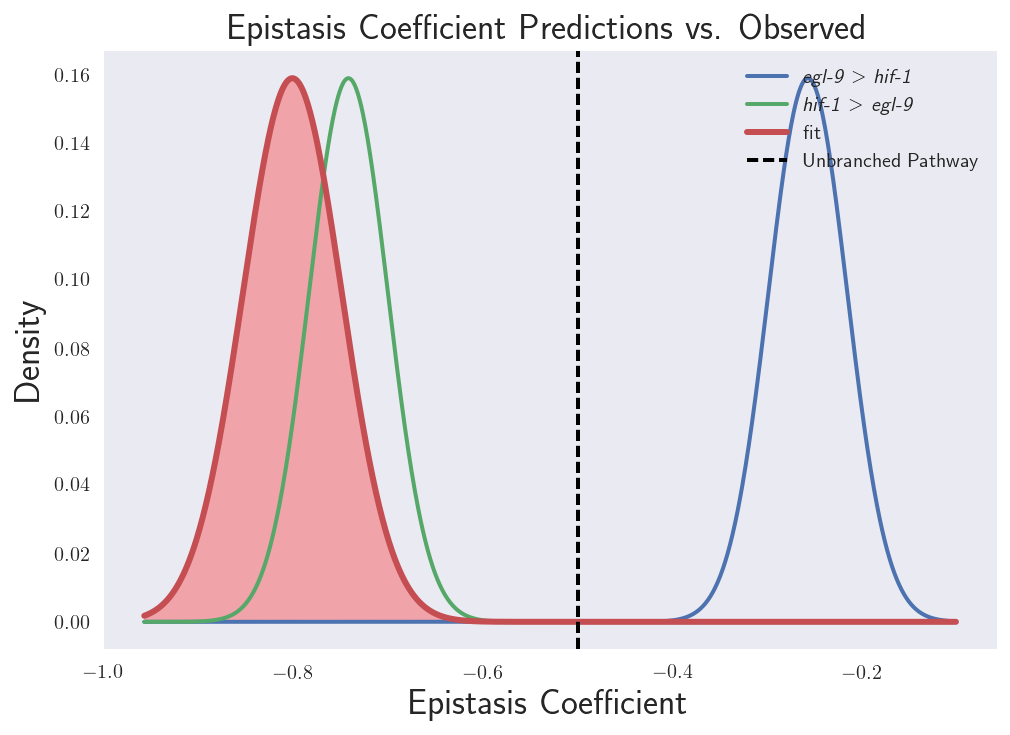

In [221]:
curves([x_over_y.params[0], y_over_x.params[0], actual.params[0]],
       [x_over_y.bse[0], y_over_x.bse[0], actual.bse[0]],
       labels=[label(letter1, letter2), label(letter2, letter1), 'fit'],)
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

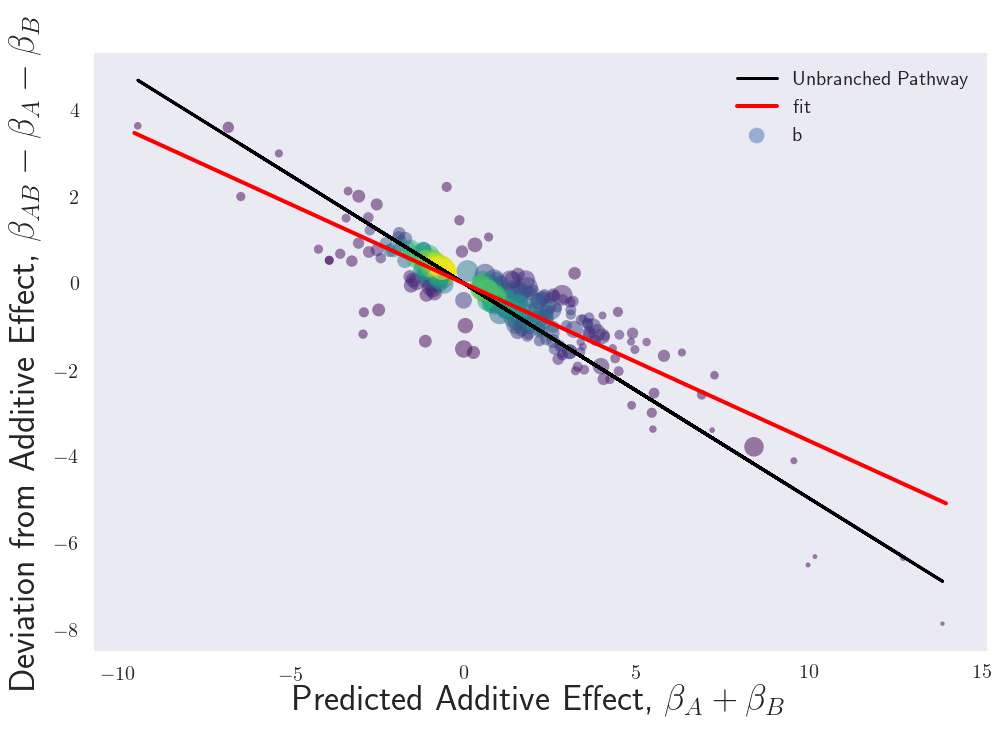

In [209]:
letter1 = 'e'
letter2 = 'd'
double = genvar.double_mapping['b' + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)

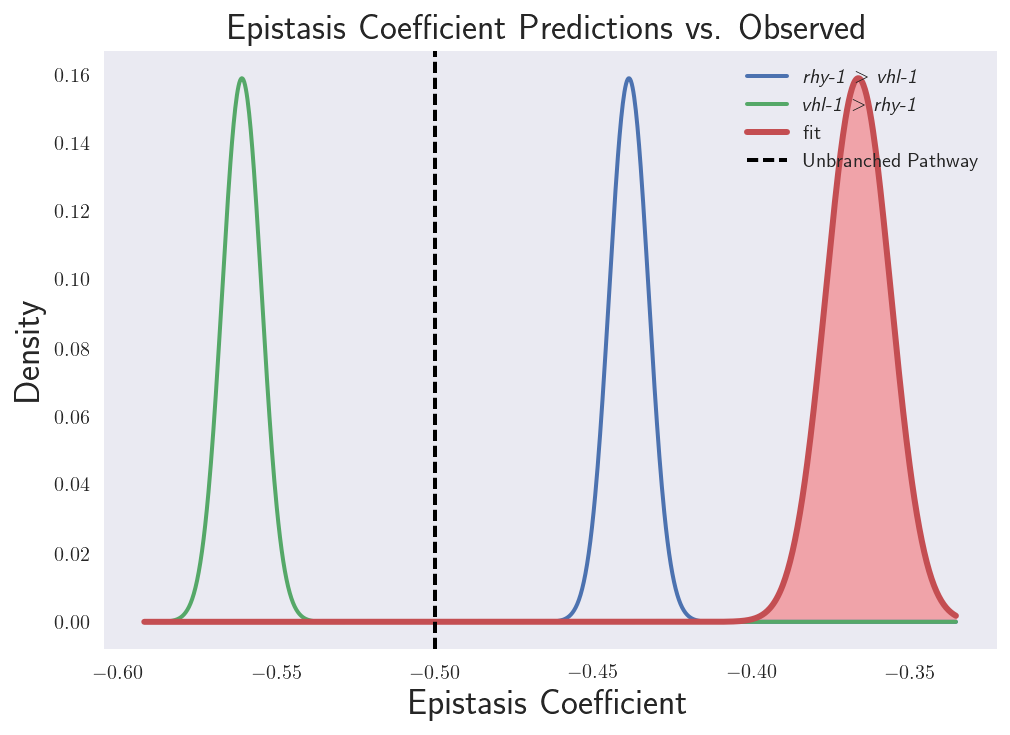

In [210]:
curves([x_over_y.params[0], y_over_x.params[0], actual.params[0]],
       [x_over_y.bse[0], y_over_x.bse[0], actual.bse[0]],
       labels=[label(letter1, letter2), label(letter2, letter1), 'fit'],)

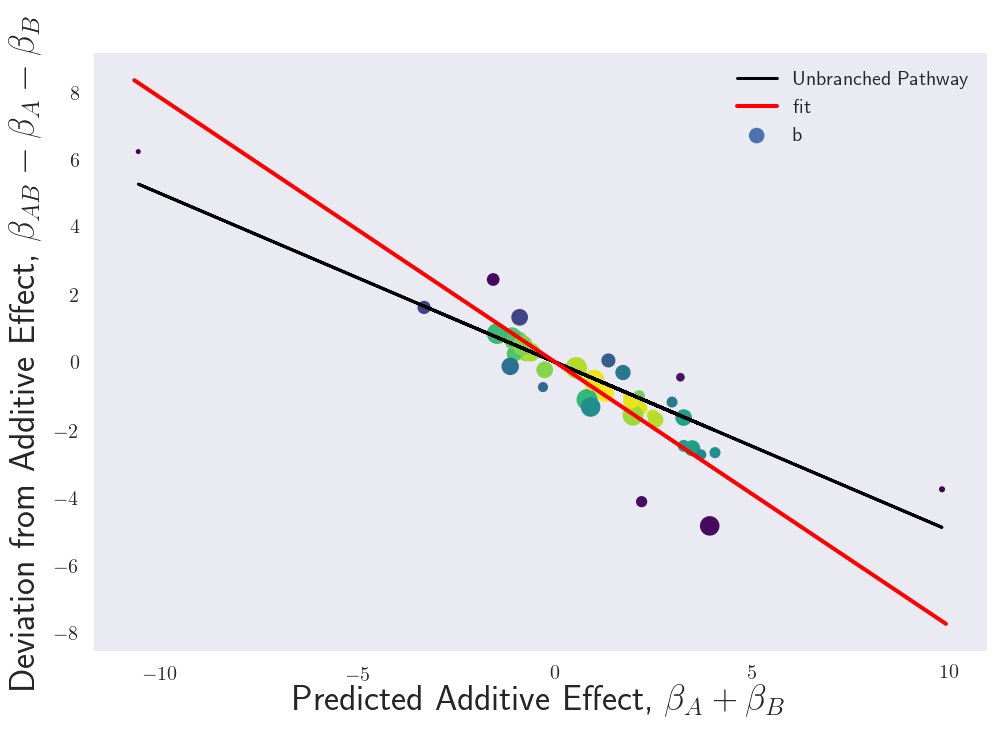

In [211]:
letter1 = 'e'
letter2 = 'c'
double = genvar.double_mapping['b' + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)

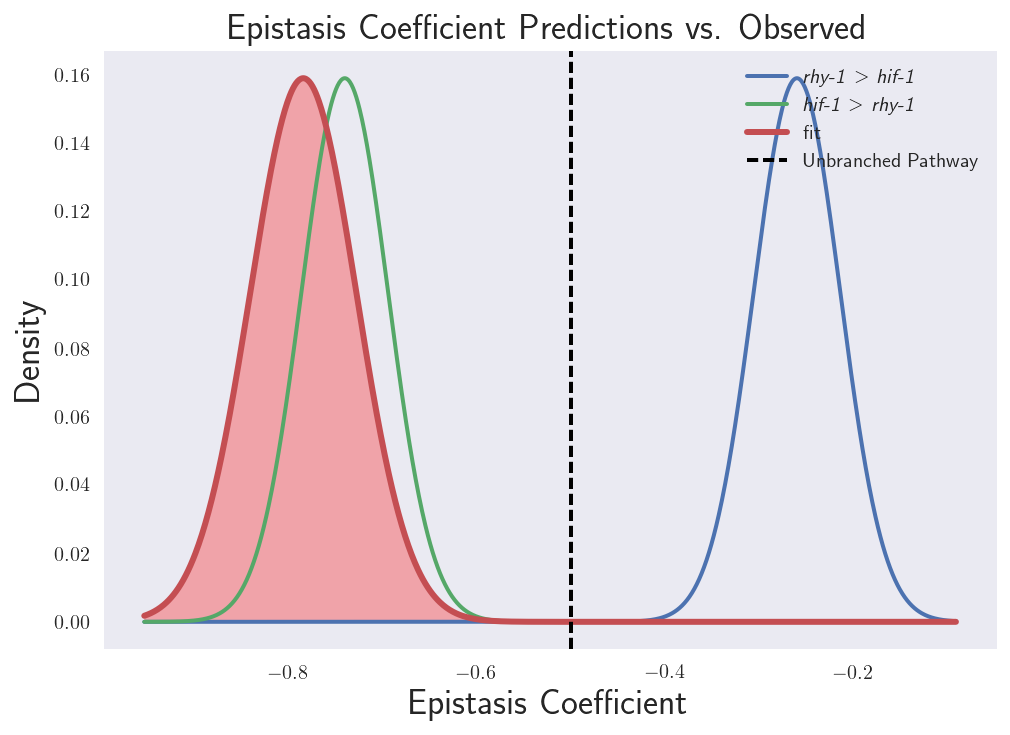

In [212]:
curves([x_over_y.params[0], y_over_x.params[0], actual.params[0]],
       [x_over_y.bse[0], y_over_x.bse[0], actual.bse[0]],
       labels=[label(letter1, letter2), label(letter2, letter1), 'fit'],)